# Brooklyn Restaurant Breakdown by Continental Cuisine

### This notebook will contain the code to download New York City neighborhood longitude and latitude data.  This data will be linked to the foursquare data resource to determine all businesses within a 1.5 km distance to the longitude and latitude neighborhood location.  Because of the data limitation of foursquare's non-pay service only one New York City Bourough will be analyzed: Brooklyn.  

### A thriving multi-ethnic restaurant presence may help determine nieghborhoods most likely to support a multi-ethnic grocery store.  Foursquare data will be used to identify ethnic restaurants within a 1.5 km radius of each nieghborhood's longitude/latitude location.  These restaurants will be placed into Asian, Hispanic, or Middle Eastern categories.  Counts of the number of restaurants in each of the three primary categories will be cauculated for each neighborhood.  This data will be placed into a k-means algorithm to cluster the neighborhoods by restaurant type.  

## Step 1 - Import Libraries

In [93]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          90 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geographiclib-1.49   | 32 KB     | ##################################### | 100% 
geopy-1.20.0         | 57 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages

## Download New York CIty neighborhood data from  https://cocl.us/new_york_dataset


In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


## Place data into pandas dataframe

In [8]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

neighborhoods.head()

The dataframe has 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Create Variable for Brooklyn Data

In [9]:
Brooklyn_data = neighborhoods[neighborhoods['Borough']=='Brooklyn'].reset_index(drop=True)
Brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


## Define 4square credentials

In [10]:
CLIENT_ID = '1S0T3YF4SXLARCEQX3KQ1SNVLUTCG2EIXIDO4K2HCT4YNDDE' # your Foursquare ID
CLIENT_SECRET = 'P2NU3TENE4PXNUCH2OMOPN4O21BW5ZBOKXRY0ZM5LFE3ESVQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1S0T3YF4SXLARCEQX3KQ1SNVLUTCG2EIXIDO4K2HCT4YNDDE
CLIENT_SECRET:P2NU3TENE4PXNUCH2OMOPN4O21BW5ZBOKXRY0ZM5LFE3ESVQ


## Function to retrieve venue information based on neighborhood longitude and latitude

In [11]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=15, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Obtain Venue information for every Brooklyn Neighborhood

In [13]:
Brooklyn_venues = getNearbyVenues(names=Brooklyn_data['Neighborhood'],
                                   latitudes=Brooklyn_data['Latitude'],
                                   longitudes=Brooklyn_data['Longitude']
                                  )


Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [94]:

print('There are {} uniques categories.'.format(len(Brooklyn_venues['Venue Category'].unique())))

There are 190 uniques categories.


## Find all Brooklyn venues by neighborhood

In [38]:
# one hot encoding
Brooklyn_onehot = pd.get_dummies(Brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Brooklyn_onehot['Neighborhood'] = Brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Brooklyn_onehot.columns[-1]] + list(Brooklyn_onehot.columns[:-1])
Brooklyn_onehot = Brooklyn_onehot[fixed_columns]


Brooklyn_onehot.head(20)


,Yoga Studio,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bath House,Beach,Beer Garden,Beer Store,Big Box Store,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Event Space,Factory,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Non-Profit,Noodle House,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Polish Restaurant,Pub,Record Shop,Restaurant,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stables,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Track,Trail,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Compress all neighborhood venues into a single row

In [59]:
Brooklyn_grouped=Brooklyn_onehot.groupby('Neighborhood').sum().reset_index()
Brooklyn_grouped.head()
Brooklyn_grouped.shape

(70, 190)

## Breakdown restaurants into Asian, Hispanic, or Middle Eastern Categories.  Sum across the restaurants in each category to calculate total number of restaurants in each category

In [72]:
Brooklyn_restAsian=Brooklyn_grouped[['Neighborhood', 'Bubble Tea Shop', 'Burmese Restaurant', 'Cantonese Restaurant', 'Chinese Restaurant', 'Dumpling Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Noodle House', 'Sushi Restaurant', 'Taiwanese Restaurant', 'Thai Restaurant', 'Tibetan Restaurant', 'Vietnamese Restaurant']]
ACopyBrook=Brooklyn_restAsian.sum(axis=1)

Brooklyn_restHisp=Brooklyn_grouped[['Neighborhood', 'Arepa Restaurant', 'Caribbean Restaurant', 'Cuban Restaurant', 'Empanada Restaurant', 'Latin American Restaurant', 'Mexican Restaurant', 'Peruvian Restaurant', 'South American Restaurant', 'Taco Place']]
AHisBrook=Brooklyn_restHisp.sum(axis=1)
#Brooklyn_rest['HSumBrook']=AHisBrook

Brooklyn_restME=Brooklyn_grouped[['Neighborhood', 'Greek Restaurant', 'Halal Restaurant', 'Israeli Restaurant', 'Lebanese Restaurant', 'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'Eastern European Restaurant', 'Russian Restaurant', 'Turkish Restaurant']]
MEBrook=Brooklyn_restME.sum(axis=1)

BrooklynRestaurants=pd.DataFrame()

BrooklynRestaurants['Neighborhood']=Brooklyn_grouped['Neighborhood']
BrooklynRestaurants['ARestT']=ACopyBrook
BrooklynRestaurants['HRestT']=AHisBrook
BrooklynRestaurants['MERestT']=MEBrook
BrooklynRestaurants['RestT']=BrooklynRestaurants.sum(axis=1)


BrooklynRestaurants

,Neighborhood,ARestT,HRestT,MERestT,RestT
0,Bath Beach,2,0,0,2
1,Bay Ridge,0,1,2,3
2,Bedford Stuyvesant,0,1,0,1
3,Bensonhurst,2,0,0,2
4,Bergen Beach,0,1,0,1
5,Boerum Hill,2,0,1,3
6,Borough Park,1,0,1,2
7,Brighton Beach,0,0,2,2
8,Broadway Junction,2,1,0,3
9,Brooklyn Heights,2,0,0,2


## Histogram of number of ethnic restaurants per neighborhood

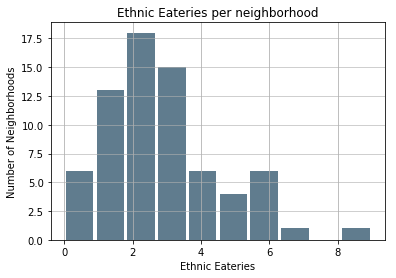

In [68]:
import matplotlib.pyplot as plt
CopyBrook=BrooklynRestaurants['RestT']
CopyBrook.plot.hist(grid=True, rwidth=0.9,
                   color='#607c8e')
plt.title('Ethnic Eateries per neighborhood')
plt.xlabel('Ethnic Eateries')
plt.ylabel('Number of Neighborhoods')
plt.grid(axis='y', alpha=0.75)

## Run K-Means to cluster neighborhoods by ethnic Restaurant

In [97]:
# set number of clusters
kclusters = 5

BrooklynRest_grouped_clustering = BrooklynRestaurants.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BrooklynRest_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1, 1,
       0, 3, 4, 0, 1, 4, 1, 2], dtype=int32)

## Add clustering labels to Brooklyn Restaurants dataset

In [98]:
BrooklynRestaurants['Cluster Labels']=kmeans.labels_

Brooklyn_merged = Brooklyn_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Brooklyn_merged = Brooklyn_merged.join(BrooklynRestaurants.set_index('Neighborhood'), on='Neighborhood')

Brooklyn_merged.head(30) # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,ARestT,HRestT,MERestT,RestT,Cluster Labels
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,1,2,3,1
1,Brooklyn,Bensonhurst,40.611009,-73.995180,2,0,0,2,1
2,Brooklyn,Sunset Park,40.645103,-74.010316,2,3,0,5,2
3,Brooklyn,Greenpoint,40.730201,-73.954241,0,2,0,2,0
4,Brooklyn,Gravesend,40.595260,-73.973471,0,0,2,2,1
5,Brooklyn,Brighton Beach,40.576825,-73.965094,0,0,2,2,1
6,Brooklyn,Sheepshead Bay,40.586890,-73.943186,2,0,4,6,3
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,1,0,3,4,3
8,Brooklyn,Flatbush,40.636326,-73.958401,1,1,1,3,1
9,Brooklyn,Crown Heights,40.670829,-73.943291,0,1,0,1,0


## List Restaurants by kmeans group

## Cluster 1

In [99]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 0, Brooklyn_merged.columns[[1] + list(range(4, Brooklyn_merged.shape[1]))]]

,Neighborhood,ARestT,HRestT,MERestT,RestT,Cluster Labels
3,Greenpoint,0,2,0,2,0
9,Crown Heights,0,1,0,1,0
17,Bedford Stuyvesant,0,1,0,1,0
19,Cobble Hill,1,0,0,1,0
21,Red Hook,0,0,0,0,0
22,Gowanus,1,0,0,1,0
24,Park Slope,1,0,0,1,0
26,East New York,0,1,0,1,0
27,Starrett City,0,0,0,0,0
28,Canarsie,0,2,0,2,0


## Cluster 2

In [100]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 1, Brooklyn_merged.columns[[1] + list(range(4, Brooklyn_merged.shape[1]))]]

,Neighborhood,ARestT,HRestT,MERestT,RestT,Cluster Labels
0,Bay Ridge,0,1,2,3,1
1,Bensonhurst,2,0,0,2,1
4,Gravesend,0,0,2,2,1
5,Brighton Beach,0,0,2,2,1
8,Flatbush,1,1,1,3,1
12,Windsor Terrace,1,0,1,2,1
15,Williamsburg,0,1,2,3,1
18,Brooklyn Heights,2,0,0,2,1
20,Carroll Gardens,1,0,1,2,1
33,Bath Beach,2,0,0,2,1


## Cluster 3

In [101]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 2, Brooklyn_merged.columns[[1] + list(range(4, Brooklyn_merged.shape[1]))]]

,Neighborhood,ARestT,HRestT,MERestT,RestT,Cluster Labels
2,Sunset Park,2,3,0,5,2
13,Prospect Heights,1,3,0,4,2
14,Brownsville,0,3,0,3,2
16,Bushwick,0,4,0,4,2
23,Fort Greene,1,2,1,4,2
25,Cypress Hills,0,3,0,3,2
29,Flatlands,1,2,0,3,2
42,Prospect Lefferts Gardens,2,2,0,4,2
44,City Line,0,3,0,3,2
50,North Side,3,2,0,5,2


## Cluster 4

In [102]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 3, Brooklyn_merged.columns[[1] + list(range(4, Brooklyn_merged.shape[1]))]]

,Neighborhood,ARestT,HRestT,MERestT,RestT,Cluster Labels
6,Sheepshead Bay,2,0,4,6,3
7,Manhattan Terrace,1,0,3,4,3
11,Kensington,4,0,1,5,3
31,Manhattan Beach,1,0,5,6,3
35,Dyker Heights,2,0,2,4,3
52,Ocean Parkway,3,0,3,6,3
66,Homecrest,5,1,1,7,3


## Cluster 5

In [103]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 4, Brooklyn_merged.columns[[1] + list(range(4, Brooklyn_merged.shape[1]))]]

,Neighborhood,ARestT,HRestT,MERestT,RestT,Cluster Labels
10,East Flatbush,2,7,0,9,4
69,Erasmus,0,6,0,6,4


## Cluster 6

In [104]:
Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 5, Brooklyn_merged.columns[[1] + list(range(4, Brooklyn_merged.shape[1]))]]

,Neighborhood,ARestT,HRestT,MERestT,RestT,Cluster Labels


## Map of clusters

In [105]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Brooklyn_merged['Latitude'], Brooklyn_merged['Longitude'], Brooklyn_merged['Neighborhood'], Brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of New York City are 40.6501038, -73.9495823.
